In [1]:
# Set the backend to legacy keras as this is what the pre-trained model expects
# Reduce TensorFlow warnings
# Set backend to TensorFlow
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision, layers
from skimage.transform import resize
import nibabel as nib
import re
import cv2
from skimage import transform
import time
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

2025-09-29 19:40:07.161919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759138807.178309 2522209 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759138807.183388 2522209 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759138807.196490 2522209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759138807.196510 2522209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759138807.196512 2522209 computation_placer.cc:177] computation placer alr

In [3]:
# Set memory growth for GPUs
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


## Preprocessing: Extract 2D slices from 3D OCT volumes

In [ ]:
# Set the classes based on folder names
CLASSES = ("AD", "CO", "YA", "AQ")

def infer_class(path: str) -> str:
    """Function infer_class to infer class from file path

        Args:
            path (str): File path

        Returns:
            str: Inferred class label

    """

    parent = os.path.basename(os.path.dirname(path)).upper()
    # infer class from parent folder name
    for c in CLASSES:
        if parent.startswith(c):
            return c
    return "UNKNOWN"

def load_volume_like(path: str) -> np.ndarray:
    """Function load_volume_like to load 3D volume or 2D image

        Args:
            path (str): File path

        Returns:
            np.ndarray: Loaded volume or image with shape (H, W, D) or (H, W, 1)

    """
    # load 3D volume or 2D image
    p = path.lower()
    # NIfTI or HDR format
    if p.endswith((".hdr", ".nii", ".nii.gz")):
        vol = nib.load(path).get_fdata()
        vol = np.asarray(vol, dtype=np.float32)
        # (H,W,D) or (H,W,D,1)
        if vol.ndim == 4:
            vol = vol[..., 0]
        if vol.ndim == 2:
            vol = vol[..., None]
        if vol.ndim != 3:
            raise ValueError(f"Unsupported dims {vol.ndim} for {path}")
        return vol
    # DICOM format
    else:
        # DICOM series in a folder
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        # single 2D image
        if img is None:
            raise ValueError(f"Failed to read: {path}")
        # convert to grayscale if needed
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img.astype(np.float32)[..., None]

def normalize01(x: np.ndarray) -> np.ndarray:
    """Function normalize01 to normalize array to [0, 1]

        Args:
            x (np.ndarray): Input array

        Returns:
            np.ndarray: Normalized array

    """
    m = float(x.max())
    # avoid division by zero
    return x / m if m > 0 else x

def center_k_indices(D: int, k: int) -> np.ndarray:
    """Function center_k_indices to get k center slice indices

        Args:
            D (int): Total number of slices
            k (int): Number of center slices to extract

        Returns:
            np.ndarray: Array of k center slice indices

    """
    # ensure k is at least 1 and at most D
    k = max(1, int(k))
    # ensure k does not exceed D
    c = D // 2
    half = k // 2
    # compute start and end indices
    start = max(0, c - half)
    end = min(D, start + k)
    # adjust start if end exceeds D
    start = max(0, end - k)
    return np.arange(start, end, dtype=int)

def nonempty_mask(vol: np.ndarray, min_nonzero_ratio=0.01, min_std=1e-6) -> np.ndarray:
    """Function nonempty_mask to get indices of non-empty slices

        Args:
            vol (np.ndarray): Input volume with shape (H, W, D)
            min_nonzero_ratio (float): Minimum ratio of non-zero pixels to consider a slice non-empty
            min_std (float): Minimum standard deviation to consider a slice non-empty

        Returns:
            np.ndarray: Array of indices of non-empty slices

    """
    # vol is (H, W, D)
    H, W, D = vol.shape
    keep = []
    # check each slice
    for z in range(D):
        sl = vol[..., z]
        if (np.count_nonzero(sl) / (H * W) >= min_nonzero_ratio) and (sl.std() >= min_std):
            keep.append(z)
    return np.array(keep, dtype=int)

def extract_slices(
    address,
    out_root="./oct_slices",
    image_size=(50, 50),
    slice_strategy="k_center",
    k_center=5,
    min_nonzero_ratio=0.01,
    min_std=1e-6,
    dry_run=False,
    verbose=True
):
    """Function extract_slices to extract 2D slices from 3D volumes

        Args:
            address (str): Root directory containing 3D volumes
            out_root (str): Output directory to save extracted slices
            image_size (tuple): Desired image size (H, W) for the output slices
            slice_strategy (str): Strategy to select slices ("middle", "k_center", "all_nonempty")
            k_center (int): Number of center slices to extract if slice_strategy is "k_center"
            min_nonzero_ratio (float): Minimum ratio of non-zero pixels to consider a slice non-empty
            min_std (float): Minimum standard deviation to consider a slice non-empty
            dry_run (bool): If True, only scan files without saving
            verbose (bool): If True, print progress and summary

        Returns:
            total (int): Total number of extracted slices
            per_class (dict): Dictionary with counts of extracted slices per class

    """
    # scan for supported files
    supported = (".hdr", ".nii", ".nii.gz", ".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp", ".dcm")
    paths = []
    for root, _, files in os.walk(address):
        for f in files:
            if f.lower().endswith(supported):
                paths.append(os.path.join(root, f))
    if verbose:
        print(f"Found {len(paths)} files under {address}")

    if not dry_run:
        for c in CLASSES:
            os.makedirs(os.path.join(out_root, c), exist_ok=True)
    # process each file
    total = 0
    per_class = {c: 0 for c in CLASSES}
    per_class["UNKNOWN"] = 0
    # sort paths for reproducibility
    for path in paths:
        cls = infer_class(path)
        vol = load_volume_like(path)
        vol = normalize01(vol)
        H, W, D = vol.shape

        # extract middle slice
        if slice_strategy == "middle":
            idxs = np.array([D // 2], dtype=int)
        # extract k center slices
        elif slice_strategy == "k_center":
            idxs = center_k_indices(D, k_center)
        # extract all non-empty slices
        elif slice_strategy == "all_nonempty":
            idxs = nonempty_mask(vol, min_nonzero_ratio, min_std)
            if idxs.size == 0:
                idxs = np.array([D // 2], dtype=int)
        else:
            raise ValueError("slice_strategy must be 'middle', 'k_center', or 'all_nonempty'")

        # update counts
        total += len(idxs)
        # update per-class counts
        per_class[cls] = per_class.get(cls, 0) + len(idxs)

        if not dry_run and cls in CLASSES:
            base = os.path.splitext(os.path.basename(path))[0]
            out_dir = os.path.join(out_root, cls)
            for z in idxs:
                sl = vol[..., z]
                sl = resize(sl, image_size, order=1, preserve_range=True, anti_aliasing=True)
                sl = normalize01(sl)
                out_path = os.path.join(out_dir, f"{base}_z{z:03d}.png")
                cv2.imwrite(out_path, (sl * 255).astype(np.uint8))

    if verbose:
        print(f"Summary (dry_run={dry_run}): total={total}, per_class={per_class}")
    return total, per_class

if __name__ == "__main__":
    DATA_DIR = "../data/[[[OCT RAW FOR DRYAD]]][2020-01JAN-16]"
    extract_slices(
        address=DATA_DIR,
        out_root="./oct_slices_scratch",
        image_size=(224, 224),
        # This refers to the way the 3D images will be sliced into 2D images
        slice_strategy="k_center",
        # Number of center slices to extract if slice_strategy is "k_center"
        k_center=5,
        dry_run=False,
        verbose=True,
    )
# extracted 2D slice image is not appropriate for the dataset. It shows a xy graph
out_root = "./oct_slices_scratch"
target = os.path.join(out_root, "CO", "CO100_DARK_MARKED_vertex_z000.png")

if os.path.exists(target):
    os.remove(target)
    print("Deleted:", target)

Found 377 files under ./[[[OCT RAW FOR DRYAD]]][2020-01JAN-16]
Summary (dry_run=False): total=1849, per_class={'AD': 552, 'CO': 549, 'YA': 632, 'AQ': 116, 'UNKNOWN': 0}
Deleted: ./oct_slices_scratch/CO/CO100_DARK_MARKED_vertex_z000.png


## Dataloader: Load 2D slices for training

In [5]:
# Supported image extensions
SUPPORTED_IMG_EXTS = ('.png')

def _cohort_from_path(path: str) -> str:
    """Function _cohort_from_path to infer cohort from file path

        Args:
            path (str): File path

        Returns:
            str: Inferred cohort label

    """
    # infer cohort from parent folder name
    parent = os.path.basename(os.path.dirname(path)).upper()
    for k in ('AD', 'CO', 'YA', 'AQ'):
        if parent.startswith(k):
            return k
    return 'UNKNOWN'

def _label_from_cohort(cohort: str, scheme: str = 'binary') -> int:
    """Function _label_from_cohort to map cohort to label

        Args:
            cohort (str): Cohort label
            scheme (str): Labeling scheme ('binary' or 'multi')

        Returns:
            int: Mapped label

    """
    # map cohort to label
    if scheme == 'binary':
        return 1 if cohort == 'AD' else 0
    mapping = {'AD': 0, 'CO': 1, 'YA': 2, 'AQ': 3}
    return mapping.get(cohort, -1)

def _subject_id_from_path(path: str) -> str:
    """Function _subject_id_from_path to extract subject ID from file path

        Args:
            path (str): File path

        Returns:
            str: Extracted subject ID

    """
    # extract subject ID from parent folder or filename
    parent = os.path.basename(os.path.dirname(path))
    m = re.search(r'(\d+)', parent)
    if m:
        return f"{parent[:2].upper()}{m.group(1)}"
    base = os.path.splitext(os.path.basename(path))[0]
    m = re.search(r'(\d+)', base)
    return m.group(1) if m else base

def _normalize01(img: np.ndarray) -> np.ndarray:
    """Function _normalize01 to normalize image to [0, 1]

        Args:
            img (np.ndarray): Input image

        Returns:
            np.ndarray: Normalized image

    """
    # normalize to [0, 1]
    m = img.max() if img.size else 1.0
    return img / (m if m != 0 else 1.0)

def load_any_image(path, image_size):
    """Function load_any_image to load and preprocess an image

        Args:
            path (str): File path
            image_size (tuple): Desired image size (H, W, C)

        Returns:
            np.ndarray: Preprocessed image

    """
    # load image and resize to image_size
    H, W, C = image_size
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # ensure image is read correctly
    if img is None:
        raise ValueError(f"Failed to read image: {path}")
    # convert to float32
    img = img.astype('float32')
    # normalize to [0, 1]
    img = _normalize01(img)
    # ensure 3 channels
    if C == 1:
        img = img[:, :, None]
    else:
        img = np.repeat(img[:, :, None], C, axis=2)
    # resize to (H, W, C)
    img_resized = transform.resize(
        img, (H, W, C), order=1, preserve_range=True, anti_aliasing=True
    ).astype('float32')
    return img_resized

def read_data(image_size=(50, 50, 1), address='./oct_slices_pretrained', flip=False, debug=False, label_scheme='binary'):
    """Function read_data to load dataset from directory

        Args:
            image_size (tuple): Desired image size (H, W, C)
            address (str): Root directory containing images
            flip (bool): If True, augment data by horizontal flipping
            debug (bool): If True, print debug information
            label_scheme (str): Labeling scheme ('binary' or 'multi')

        Returns:
            X (np.ndarray): Loaded images of shape (N, H, W, C)
            y (np.ndarray): Corresponding labels of shape (N,)
            paths (list): List of file paths for each image
            groups (np.ndarray): Array of subject IDs for each image

    """
    # scan for image files
    paths = []
    for root, _, files in os.walk(address):
        for f in files:
            if f.lower().endswith(SUPPORTED_IMG_EXTS):
                paths.append(os.path.join(root, f))
    if debug:
        print(f"[scan] {address} -> {len(paths)} files")
    if not paths:
        raise RuntimeError(f"No images found under '{address}'")

    # load and preprocess images
    X, y, keep_paths, groups = [], [], [], []
    for p in paths:
        cohort = _cohort_from_path(p)
        lbl = _label_from_cohort(cohort, scheme=label_scheme)
        if lbl < 0:
            if debug:
                print(f"[skip] Unknown cohort for {p}")
            continue
        # load image
        img = load_any_image(p, image_size)
        X.append(img); y.append(lbl); keep_paths.append(p)
        groups.append(_subject_id_from_path(p))

        # data augmentation by flipping
        if flip:
            flipped = cv2.flip(img, 1)
            X.append(flipped); y.append(lbl); keep_paths.append(p + " [flipped]")
            groups.append(_subject_id_from_path(p))

    # convert to numpy arrays
    X = np.stack(X, axis=0).astype('float32')
    # flatten y to 1D array
    y = np.asarray(y, dtype=np.int64)
    # paths
    groups = np.asarray(groups)

    # debug info
    if label_scheme == 'binary' and debug:
        frac_ad = (y == 1).mean()
        print(f"Fraction AD: {frac_ad:.3f} ({(y==1).sum()}/{len(y)})")

    return X, y, keep_paths, groups

# test the dataloader
if __name__ == "__main__":
    X, y, paths, groups = read_data(debug=True)
    print("Loaded:", X.shape, y.shape, len(paths), groups.shape)


[scan] ./oct_slices_pretrained -> 1848 files
Fraction AD: 0.299 (552/1848)
Loaded: (1848, 50, 50, 1) (1848,) 1848 (1848,)


## Vision Transformer (ViT) model for classification

In [6]:
# Parameters can be adjusted in BayesSearchCV section
class ViTWrapper(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        # Projection dimension for the transformer
        projection_dim=64,
        # Size of the image patches
        patch_size=5,
        # Number of transformer layers
        transformer_layers=3,
        # Number of attention heads
        num_heads=4,
        # MLP head units
        mlp_head_unit_1=64,
        # MLP head units
        mlp_head_unit_2=32,
        epochs=100,
        batch_size=32,
        lr=2e-4,
        weight_decay=1e-4,
        dropout_rate=0.2,
        class_weight="balanced",
        logdir_root=None,
        random_state=42,
    ):
        """Function __init__ to initialize ViTWrapper

            Args:
                projection_dim (int): Dimension of the projection layer
                patch_size (int): Size of the image patches
                transformer_layers (int): Number of transformer layers
                num_heads (int): Number of attention heads
                mlp_head_unit_1 (int): Units in the first MLP head layer
                mlp_head_unit_2 (int): Units in the second MLP head layer
                epochs (int): Number of training epochs
                batch_size (int): Training batch size
                lr (float): Learning rate
                weight_decay (float): Weight decay for AdamW optimizer
                dropout_rate (float): Dropout rate
                class_weight (str or None): Class weighting strategy
                logdir_root (str or None): Root directory for TensorBoard logs
                random_state (int): Random seed for reproducibility

        """
        self.projection_dim = projection_dim
        self.patch_size = patch_size
        self.transformer_layers = transformer_layers
        self.num_heads = num_heads
        self.mlp_head_unit_1 = mlp_head_unit_1
        self.mlp_head_unit_2 = mlp_head_unit_2
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.class_weight = class_weight
        self.logdir_root = logdir_root
        self.dropout_rate = dropout_rate
        self.random_state = random_state

    def _build_model(self, input_shape):
        """Function _build_model to build the ViT model

            Args:
                input_shape (tuple): Shape of the input images (H, W, C)

            Returns:
                model (keras.Model): Compiled Keras model

        """
        def mlp(x, hidden_units):
            """Function mlp to create MLP layers

                Args:
                    x (tf.Tensor): Input tensor
                    hidden_units (list): List of hidden units for each layer

                Returns:
                    tf.Tensor: Output tensor after MLP layers

            """
            for units in hidden_units:
                x = layers.Dense(units, activation=keras.activations.gelu)(x)
                x = layers.Dropout(self.dropout_rate)(x)
            return x

        class Patches(layers.Layer):
            def __init__(self, patch_size):
                """Function __init__ to initialize Patches layer

                    Args:
                        patch_size (int): Size of the image patches

                """
                super().__init__()
                self.patch_size = patch_size

            def call(self, images):
                """Function call to extract patches from images

                    Args:
                        images (tf.Tensor): Input images of shape (B, H, W, C)

                    Returns:
                        tf.Tensor: Extracted patches of shape (B, num_patches, patch_dim)

                """
                ps = self.patch_size
                b = tf.shape(images)[0]
                h = tf.shape(images)[1]
                w = tf.shape(images)[2]
                c = tf.shape(images)[3]

                # number of patches along each spatial dim
                nph = h // ps
                npw = w // ps

                # extract non-overlapping patches
                patches = tf.image.extract_patches(
                    images=images,
                    sizes=[1, ps, ps, 1],
                    strides=[1, ps, ps, 1],
                    rates=[1, 1, 1, 1],
                    padding="VALID",
                )

                patch_dim = ps * ps * c
                patches = tf.reshape(patches, tf.stack([b, nph * npw, patch_dim]))
                return patches

            def get_config(self):
                """Function get_config to get layer configuration

                    Returns:
                        dict: Configuration dictionary

                """
                return {"patch_size": self.patch_size}

        class PatchEncoder(layers.Layer):
            def __init__(self, num_patches, projection_dim):
                """Function __init__ to initialize PatchEncoder layer

                    Args:
                        num_patches (int): Number of patches
                        projection_dim (int): Dimension of the projection layer

                """
                super().__init__()
                self.num_patches = num_patches
                self.projection = layers.Dense(units=projection_dim)
                self.position_embedding = layers.Embedding(
                    input_dim=num_patches, output_dim=projection_dim
                )

            def call(self, patch):
                """Function call to encode patches with positional embeddings

                    Args:
                        patch (tf.Tensor): Input patches of shape (B, num_patches, patch_dim)

                    Returns:
                        tf.Tensor: Encoded patches of shape (B, num_patches, projection_dim)

                """
                pos = tf.expand_dims(tf.range(self.num_patches, dtype=tf.int32), axis=0)
                x = self.projection(patch)
                return x + self.position_embedding(pos)

            def get_config(self):
                """Function get_config to get layer configuration

                    Returns:
                        dict: Configuration dictionary

                """
                return {"num_patches": self.num_patches}

        # Input layer
        inputs = keras.Input(shape=input_shape)

        # Ensure the patches tile perfectly
        assert input_shape[0] % self.patch_size == 0 and input_shape[1] % self.patch_size == 0, \
            f"patch_size {self.patch_size} must evenly divide {input_shape[:2]}"

        # Number of patches
        num_patches = (input_shape[0] // self.patch_size) * (input_shape[1] // self.patch_size)

        # Create patches and encode them
        x = Patches(self.patch_size)(inputs)

        # Encode the patches
        x = PatchEncoder(num_patches, self.projection_dim)(x)

        # Transformer blocks
        for _ in range(self.transformer_layers):
            x1 = layers.LayerNormalization(epsilon=1e-6)(x)
            attn = layers.MultiHeadAttention(
                num_heads=self.num_heads,
                key_dim=self.projection_dim,
                dropout=self.dropout_rate
            )(x1, x1)
            # Add & Norm
            attn = layers.Dropout(self.dropout_rate)(attn)
            x2 = layers.Add()([attn, x])

            # MLP
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            x3 = mlp(x3, [self.projection_dim * 2, self.projection_dim])
            # Add & Norm
            x = layers.Add()([x3, x2])

        # Classification head
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        # Global average pooling
        x = layers.Flatten()(x)
        # Dropout
        x = layers.Dropout(self.dropout_rate)(x)
        # MLP head
        x = mlp(x, [self.mlp_head_unit_1, self.mlp_head_unit_2])
        # Final output layer change to float32 for numerical stability
        outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

        # Focal loss was tried but did poorly compared to binary crossentropy
        # If using focal loss, class_weight should be None as focal loss handles class imbalance
        # jit_compile=False to avoid issues with some custom losses
        model = keras.Model(inputs, outputs)
        opt = keras.optimizers.AdamW(learning_rate=self.lr, weight_decay=self.weight_decay)
        model.compile(
            optimizer=opt,
            loss="binary_crossentropy",
            metrics=[keras.metrics.AUC(name="auc"), "accuracy"],
            jit_compile=False,
            steps_per_execution=32,
        )
        return model

    def fit(self, X, y):
        """Function fit to train the ViT model

            Args:
                X (np.ndarray): Training images of shape (N, H, W, C)
                y (np.ndarray): Corresponding labels of shape (N,)

            Returns:
                self: Fitted estimator

        """
        # Reproducibility
        tf.keras.backend.clear_session()
        tf.random.set_seed(self.random_state)
        np.random.seed(self.random_state)

        # Build model
        self.model_ = self._build_model(input_shape=X.shape[1:])

        # Callbacks
        # Early stopping, model checkpoint, TensorBoard
        callbacks = [
            keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
            keras.callbacks.ModelCheckpoint(
                "vit_scratch.h5", monitor="loss", save_best_only=True, save_weights_only=True
            ),
        ]
        if self.logdir_root:
            os.makedirs(self.logdir_root, exist_ok=True)
            run_dir = os.path.join(self.logdir_root, time.strftime("%Y%m%d-%H%M%S"))
            callbacks.append(keras.callbacks.TensorBoard(log_dir=run_dir, write_graph=True))

        # Handle class weights
        cw = None
        if self.class_weight == "balanced":
            classes = np.array([0, 1])
            w = compute_class_weight(class_weight="balanced", classes=classes, y=y.ravel())
            cw = {0: float(w[0]), 1: float(w[1])}

        # Train the model
        self.model_.fit(
            X, y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=2,
            validation_split=0,
            callbacks=callbacks,
            class_weight=cw,
        )
        return self

    def predict_proba(self, X):
        """Function predict_proba to predict class probabilities

            Args:
                X (np.ndarray): Input images of shape (N, H, W, C)

            Returns:
                np.ndarray: Predicted probabilities of shape (N, 2)

        """
        probs = self.model_.predict(X, verbose=0).ravel()
        probs = np.clip(probs, 1e-7, 1 - 1e-7)
        return np.column_stack([1.0 - probs, probs])

    def predict(self, X):
        """Function predict to predict class labels

            Args:
                X (np.ndarray): Input images of shape (N, H, W, C)

            Returns:
                np.ndarray: Predicted class labels of shape (N,)

        """
        return (self.model_.predict(X, verbose=0).ravel() >= 0.5).astype(int)

    def score(self, X, y):
        """Function score to compute accuracy

            Args:
                X (np.ndarray): Input images of shape (N, H, W, C)
                y (np.ndarray): True labels of shape (N,)

            Returns:
                float: Accuracy score

        """
        return (self.predict(X) == y.ravel()).mean()

# load data from preprocessed slices
DATA_DIR = "./oct_slices_scratch"

# Load data
X, y, paths, groups = read_data(
    image_size=(50, 50, 1),
    address=DATA_DIR,
    flip=False,
    debug=False,
    label_scheme="binary",
)
# Flatten y to 1D array of int
y = y.ravel().astype(int)

# Train/test split (group-stratified)
print("Dataset:", X.shape, " AD ratio:", y.mean())
print("Class counts:", Counter(y))

# stratify by y to maintain class balance in train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# print dataset info
print("Train:", X_tr.shape, " Test:", X_te.shape)
print("Train AD ratio:", y_tr.mean(), " Test AD ratio:", y_te.mean())

Dataset: (1848, 50, 50, 1)  AD ratio: 0.2987012987012987
Class counts: Counter({np.int64(0): 1296, np.int64(1): 552})
Train: (1663, 50, 50, 1)  Test: (185, 50, 50, 1)
Train AD ratio: 0.2988574864702345  Test AD ratio: 0.2972972972972973


## Bayesian hyperparameter optimization

In [6]:
# To find a good set of values for search, change from Categorical to Real and use a wide range. Head units, projection dim should be kept at Categorical and in multiples of 8. Batch size should be kept at Categorical
vit_params = {
    "projection_dim": Categorical([16, 24, 32, 40, 48]),
    "patch_size": Categorical([5, 10]),
    "transformer_layers": Integer(1, 5),
    "num_heads": Integer(1, 4),
    "mlp_head_unit_1": Categorical([32, 64, 96]),
    "mlp_head_unit_2": Categorical([16, 32, 64]),
    "epochs": Categorical([100]),
    "batch_size": Categorical([24]),
    "lr": Categorical([1e-3, 2e-4, 1e-4]),
    "weight_decay": Categorical([2e-4, 1e-4, 1e-3, 1e-2]),
    "dropout_rate": Categorical([0.2, 0.3, 0.4]),
}

# Custom scoring function to use predicted probabilities for ROC AUC instead of Accuracy
def roc_auc_from_proba(estimator, X, y):
    """Function roc_auc_from_proba to compute ROC AUC from predicted probabilities

        Args:
            estimator: Trained estimator
            X (np.ndarray): Input images of shape (N, H, W, C)
            y (np.ndarray): True labels of shape (N,)

        Returns:
            float: ROC AUC score

    """
    p = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, p)

# Bayesian search. Increase n_iter for more thorough search, however at the cost of GPU memory.
search = BayesSearchCV(
    estimator=ViTWrapper(logdir_root="tb_logs/vit", class_weight="balanced"),
    search_spaces=vit_params,
    n_iter=12,
    cv=cv,
    n_jobs=1,
    # Scoring can be changed to accuracy, however did worse than ROC AUC in trials
    scoring=roc_auc_from_proba,
    refit=True,
    verbose=2,
)

# fit with groups if needed
fit_kwargs = {}

# perform search
t0 = time.time()

# may take a while depending on n_iter and epochs
search.fit(X_tr, y_tr, **fit_kwargs)
print(f"\nBayesSearchCV done in {time.time()-t0:.1f}s")
print("Best CV accuracy:", search.best_score_)
print("Best params:", search.best_params_)

# get the best estimator
best_est = search.best_estimator_

# best_est.model_ is the trained Keras model
y_prob = best_est.predict_proba(X_te)[:, 1]

# reducing threshold may improve recall. Increase threshold may improve precision.
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_te, y_pred)
try:
    auc = roc_auc_score(y_te, y_prob)
except Exception:
    auc = float("nan")

# print results
print("\nHELD-OUT TEST RESULTS")
print(" Accuracy:", round(acc, 4))
print(" ROC AUC:", round(auc, 4))
print("\nConfusion matrix:\n", confusion_matrix(y_te, y_pred))
print("\nReport:\n", classification_report(y_te, y_pred, digits=4))

print("\nTo view training logs with TensorBoard:")
print("  tensorboard --logdir tb_logs/vit")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


I0000 00:00:1758440636.364556 1034782 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6042 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1758440649.575239 1034890 service.cc:152] XLA service 0x7e9708006480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758440649.575266 1034890 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
I0000 00:00:1758440649.627217 1034901 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758440650.086966 1034894 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 - 20s - loss: 0.9286 - auc: 0.4868 - accuracy: 0.5090 - 20s/epoch - 356ms/step
Epoch 2/100


KeyboardInterrupt: 

In [8]:
%load_ext tensorboard
%tensorboard --logdir "tb_logs/vit"

NameError: name 'keep_paths' is not defined

In [7]:
# Save the best model
best_est.model_.save("vit_scratch")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab43601c0>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab43601c0>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4361660>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4361660>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482995d0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482995d0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4829a560>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4829a560>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4829b4f0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4829b4f0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d44c0>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d44c0>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d5450>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d5450>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d63e0>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d63e0>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d7370>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d7370>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff43a0>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff43a0>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff71f0>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff71f0>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7be20>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7be20>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7ae90>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7ae90>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f79ea0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f79ea0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff9030>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff9030>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff9fc0>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff9fc0>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ffaf50>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ffaf50>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ffbee0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ffbee0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e08eb0>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e08eb0>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e09e40>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e09e40>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e0add0>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e0add0>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e0bdc0>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e0bdc0>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76eebb50>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76eebb50>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76eeb340>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76eeb340>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac0458c10>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac0458c10>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac0459c00>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac0459c00>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044ca90>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044ca90>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044da20>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044da20>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044e9b0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044e9b0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044f940>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044f940>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a50910>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a50910>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a518a0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a518a0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a52830>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a52830>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a53820>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a53820>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a426b0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a426b0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a436a0>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a436a0>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08694670>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08694670>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08695660>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08695660>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869d4b0>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869d4b0>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869fb80>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869fb80>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869edd0>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869edd0>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869fe80>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869fe80>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e76d0>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e76d0>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e6290>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e6290>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e66b0>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e66b0>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e4fd0>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e4fd0>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77706110>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77706110>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77707100>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77707100>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779c0d0>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779c0d0>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779d0c0>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779d0c0>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779ff10>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779ff10>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa24ee0>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa24ee0>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa25e70>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa25e70>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa26e00>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa26e00>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa27d90>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa27d90>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa68d60>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa68d60>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa69cf0>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa69cf0>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa6ace0>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa6ace0>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3c9b70>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3c9b70>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3cab60>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3cab60>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3cbaf0>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3cbaf0>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f304b20>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f304b20>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f307970>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f307970>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f348940>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f348940>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3498d0>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3498d0>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f34a860>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f34a860>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f34b7f0>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f34b7f0>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f07c0>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f07c0>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f1750>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f1750>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f2740>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f2740>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763695d0>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763695d0>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7636a5c0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7636a5c0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7636b550>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7636b550>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8744580>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8744580>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87473d0>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87473d0>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87783a0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87783a0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8779330>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8779330>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac877a2c0>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac877a2c0>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac877b250>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac877b250>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8714220>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8714220>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87151b0>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87151b0>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87161a0>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87161a0>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c25030>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c25030>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c26020>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c26020>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c26fb0>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c26fb0>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c27fa0>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c27fa0>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75cb6e30>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75cb6e30>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75cb7dc0>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75cb7dc0>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bcd90>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bcd90>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bdd20>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bdd20>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762becb0>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762becb0>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bfc40>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bfc40>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762dcc10>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762dcc10>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762ddc00>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762ddc00>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76260a90>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76260a90>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76261a80>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76261a80>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76262a10>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76262a10>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76263a00>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76263a00>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fffa890>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fffa890>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fffb820>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fffb820>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff507f0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff507f0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff51780>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff51780>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff52710>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff52710>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff536a0>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff536a0>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77658670>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77658670>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77659660>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77659660>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d44f0>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d44f0>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d54e0>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d54e0>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d6470>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d6470>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d7460>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d7460>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776f62f0>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776f62f0>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776f7280>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776f7280>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a0250>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a0250>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a11e0>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a11e0>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a2170>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a2170>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a3100>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a3100>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761280d0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761280d0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761290c0>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761290c0>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7612bf10>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7612bf10>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555cf40>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555cf40>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555ded0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555ded0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555eec0>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555eec0>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75541d50>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75541d50>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75542d40>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75542d40>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75543cd0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75543cd0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75590d00>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75590d00>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd57f3d60>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd57f3d60>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf1ea0>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf1ea0>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf2ef0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf2ef0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf0b80>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf0b80>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd57bf8b0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd57bf8b0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da741626b0>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da741626b0>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74162a10>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74162a10>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74160820>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74160820>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74162050>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74162050>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015d2a0>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015d2a0>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015f970>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015f970>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015d930>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015d930>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b44c0>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b44c0>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b7580>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b7580>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b7310>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b7310>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b73d0>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b73d0>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00371000>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00371000>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db003731c0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db003731c0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00370160>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00370160>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00373820>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00373820>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5889b10>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5889b10>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5889690>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5889690>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db702017e0>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db702017e0>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70202b90>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70202b90>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db702025c0>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db702025c0>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70200070>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70200070>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19e3b0>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19e3b0>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19e230>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19e230>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19f5b0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19f5b0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19d360>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19d360>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa6c80>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa6c80>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa5de0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa5de0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa4490>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa4490>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa5240>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa5240>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76842da0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76842da0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76843580>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76843580>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768429b0>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768429b0>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768425c0>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768425c0>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76894a60>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76894a60>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76895b70>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76895b70>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76897ac0>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76897ac0>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac85827d0>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac85827d0>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8583f70>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8583f70>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8581ea0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8581ea0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8581870>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8581870>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74eea9b0>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74eea9b0>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74eebfd0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74eebfd0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74ee9cc0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74ee9cc0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74ee9c90>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74ee9c90>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d19b40>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d19b40>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d191b0>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d191b0>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d1b6a0>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d1b6a0>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d19ea0>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d19ea0>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd584f160>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd584f160>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd584ca00>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd584ca00>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b9ba60>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b9ba60>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b9a260>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b9a260>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b98130>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b98130>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b98400>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b98400>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48357640>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48357640>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48357b80>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48357b80>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48355930>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48355930>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48354040>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48354040>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87485b0>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87485b0>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac874b970>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac874b970>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8748a30>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8748a30>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac874a320>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac874a320>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0086440>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0086440>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00879a0>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00879a0>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00865c0>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00865c0>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0087d30>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0087d30>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70286fe0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70286fe0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70285450>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70285450>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70287910>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70287910>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431c490>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431c490>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431ecb0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431ecb0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431e5c0>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431e5c0>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431d630>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431d630>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6754e20>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6754e20>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6754670>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6754670>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6757790>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6757790>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6755810>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6755810>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d87790>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d87790>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d87eb0>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d87eb0>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d852a0>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d852a0>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d84c40>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d84c40>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601a88e0>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601a88e0>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601aae60>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601aae60>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601aa7d0>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601aa7d0>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601a9300>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601a9300>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1af20>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1af20>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1a3e0>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1a3e0>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1a590>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1a590>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b19750>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b19750>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cd690>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cd690>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759ccf10>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759ccf10>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cdc30>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cdc30>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cd960>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cd960>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f269ff0>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f269ff0>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f26b850>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f26b850>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f2692d0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f2692d0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76be80>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76be80>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76b370>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76b370>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76b250>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76b250>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76a320>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76a320>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7687c0>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7687c0>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fc640>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fc640>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fd390>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fd390>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fcbe0>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fcbe0>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086ffc10>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086ffc10>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0ca90>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0ca90>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0e770>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0e770>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0c2e0>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0c2e0>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001867a0>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001867a0>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001840a0>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001840a0>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00187100>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00187100>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00184ca0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00184ca0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00185270>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00185270>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60443fa0>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60443fa0>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60440fa0>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60440fa0>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db604436a0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db604436a0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60441cf0>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60441cf0>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd58327d0>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd58327d0>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5832e30>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5832e30>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd58329e0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd58329e0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6011e410>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6011e410>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76671690>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76671690>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76673700>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76673700>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766732e0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766732e0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664b010>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664b010>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664a110>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664a110>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76648b80>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76648b80>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664a7a0>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664a7a0>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8294250>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8294250>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8295180>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8295180>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8296c80>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8296c80>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8297190>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8297190>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8287070>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8287070>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8284df0>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8284df0>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8284eb0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8284eb0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f01fa90>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f01fa90>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f01ed70>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f01ed70>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77122620>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77122620>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77122fb0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77122fb0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77120700>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77120700>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da765177c0>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da765177c0>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da765153c0>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da765153c0>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76514520>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76514520>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76516fb0>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76516fb0>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d21a0>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d21a0>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d2a10>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d2a10>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d3ac0>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d3ac0>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70276d40>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70276d40>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70275f00>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70275f00>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768bb1c0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768bb1c0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c72bb20>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c72bb20>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c72aaa0>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c72aaa0>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74f2bf10>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74f2bf10>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74f2a6b0>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74f2a6b0>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76617400>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76617400>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766160b0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766160b0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76617a90>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76617a90>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ada980>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ada980>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ad9780>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ad9780>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ad8460>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ad8460>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670c430>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670c430>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670dc60>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670dc60>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670e740>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670e740>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670ebc0>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670ebc0>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879c0d0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879c0d0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879e290>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879e290>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879cc40>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879cc40>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c786cb0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c786cb0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7865f0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7865f0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c787bb0>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c787bb0>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c787610>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c787610>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05da920>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05da920>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05da050>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05da050>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05dab90>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05dab90>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48688d30>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48688d30>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4868aa40>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4868aa40>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4868af20>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4868af20>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48688370>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48688370>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051f2b0>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051f2b0>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051f100>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051f100>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051dd80>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051dd80>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843dbd0>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843dbd0>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843f2b0>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843f2b0>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843ee90>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843ee90>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbbe721cc0>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbbe721cc0>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbbe722260>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbbe722260>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645e110>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645e110>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645c850>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645c850>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645e200>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645e200>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645f520>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645f520>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6723970>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6723970>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6723a00>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6723a00>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874f5b0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874f5b0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874c8e0>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874c8e0>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874e620>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874e620>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874db40>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874db40>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c7130>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c7130>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c7490>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c7490>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c6b60>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c6b60>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08627a60>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08627a60>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08624fa0>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08624fa0>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08626aa0>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08626aa0>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086276a0>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086276a0>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085ea350>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085ea350>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085ebe80>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085ebe80>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085eae00>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085eae00>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60388640>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60388640>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db603894b0>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db603894b0>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db603895d0>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db603895d0>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60389f60>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60389f60>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd659f0>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd659f0>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd67a90>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd67a90>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd66b60>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd66b60>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd66410>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd66410>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74252440>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74252440>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74253d90>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74253d90>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a0d00>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a0d00>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a25c0>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a25c0>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a1510>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a1510>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7039ac80>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7039ac80>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70399360>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70399360>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7039bcd0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7039bcd0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678ff40>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678ff40>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678fc40>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678fc40>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678ec80>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678ec80>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701f90f0>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701f90f0>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701fab90>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701fab90>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701f8ac0>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701f8ac0>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4855a410>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4855a410>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48559450>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48559450>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4855b6d0>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4855b6d0>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60206230>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60206230>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db602071c0>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db602071c0>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60207820>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60207820>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60204640>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60204640>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241b9cf0>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241b9cf0>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241b84f0>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241b84f0>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241bb610>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241bb610>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08153d00>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08153d00>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08152140>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08152140>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41effa0>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41effa0>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41ee380>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41ee380>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41ecb20>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41ecb20>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da773a9ed0>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da773a9ed0>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da773a9480>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da773a9480>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab49a7fa0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab49a7fa0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab49a4700>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab49a4700>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764f64a0>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764f64a0>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764f4040>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764f4040>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a7070>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a7070>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a5a50>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a5a50>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a71c0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a71c0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a6890>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a6890>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb491f30>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb491f30>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb492200>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb492200>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb491d20>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb491d20>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb493400>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb493400>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483aa5c0>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483aa5c0>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483a89a0>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483a89a0>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483a9450>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483a9450>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483aa1a0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483aa1a0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004f880>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004f880>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004df30>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004df30>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004c940>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004c940>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004f490>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004f490>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837af0>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837af0>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837cd0>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837cd0>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837e20>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837e20>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da748365f0>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da748365f0>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7aee60>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7aee60>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7aedd0>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7aedd0>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7ac700>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7ac700>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7ace80>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7ace80>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0013490>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0013490>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0011000>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0011000>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0011e70>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0011e70>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0013760>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0013760>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00139d0>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00139d0>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e448b0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e448b0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e46a10>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e46a10>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e45090>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e45090>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e45390>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e45390>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6070c40>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6070c40>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6071fc0>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6071fc0>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6073b50>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6073b50>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6070fd0>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6070fd0>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dd2a0>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dd2a0>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dca30>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dca30>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01ddc30>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01ddc30>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dd540>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dd540>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bf6a0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bf6a0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bf760>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bf760>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bc580>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bc580>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752be3b0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752be3b0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847e4d0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847e4d0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847f370>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847f370>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847ce80>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847ce80>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847c3d0>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847c3d0>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75257010>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75257010>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75255f30>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75255f30>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75257490>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75257490>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752555a0>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752555a0>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76485960>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76485960>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76486d40>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76486d40>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76485030>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76485030>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764849d0>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764849d0>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24560340>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24560340>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24560f70>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24560f70>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24563850>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24563850>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db245619c0>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db245619c0>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dd1c2eb730>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dd1c2eb730>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f196e60>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f196e60>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f194df0>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f194df0>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f197fa0>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f197fa0>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f195720>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f195720>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c970>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c970>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c190>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c190>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034eb90>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034eb90>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c070>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c070>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768aa260>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768aa260>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768aa1a0>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768aa1a0>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768a9870>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768a9870>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768a93c0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768a93c0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701eaa70>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701eaa70>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701e8040>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701e8040>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701eb220>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701eb220>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701e9a20>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701e9a20>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0bb80>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0bb80>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0ac20>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0ac20>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f095a0>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f095a0>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0b070>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0b070>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74522410>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74522410>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74520400>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74520400>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74523d00>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74523d00>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74521180>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74521180>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745aefb0>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745aefb0>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745af3d0>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745af3d0>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745addb0>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745addb0>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745ae7a0>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745ae7a0>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0030a60>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0030a60>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00306d0>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00306d0>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0030a30>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0030a30>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0033f10>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0033f10>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f5540>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f5540>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f7460>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f7460>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f4430>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f4430>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f7fd0>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f7fd0>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b4bcd0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b4bcd0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b48880>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b48880>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b496f0>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b496f0>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b4b1c0>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b4b1c0>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7fcd0>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7fcd0>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7ca90>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7ca90>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7f280>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7f280>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7e350>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7e350>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24516020>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24516020>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db245169b0>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db245169b0>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24515b10>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24515b10>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24515030>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24515030>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf1de0>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf1de0>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf3f70>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf3f70>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf1690>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf1690>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf3d60>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf3d60>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf24d0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf24d0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab65301f0>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab65301f0>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab65321a0>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab65321a0>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6531750>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6531750>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6532bc0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6532bc0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d1d80>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d1d80>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d2770>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d2770>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d01c0>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d01c0>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d01f0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d01f0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faaabc0>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faaabc0>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab43601c0>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab43601c0>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4361660>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4361660>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482995d0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482995d0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4829a560>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4829a560>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4829b4f0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4829b4f0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d44c0>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d44c0>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d5450>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d5450>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d63e0>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d63e0>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d7370>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db482d7370>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff43a0>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff43a0>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff71f0>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff71f0>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7be20>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7be20>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7ae90>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7ae90>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f79ea0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f79ea0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff9030>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff9030>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff9fc0>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ff9fc0>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ffaf50>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ffaf50>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ffbee0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ffbee0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e08eb0>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e08eb0>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e09e40>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e09e40>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e0add0>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e0add0>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e0bdc0>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76e0bdc0>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76eebb50>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76eebb50>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76eeb340>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76eeb340>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac0458c10>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac0458c10>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac0459c00>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac0459c00>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044ca90>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044ca90>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044da20>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044da20>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044e9b0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044e9b0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044f940>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac044f940>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a50910>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a50910>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a518a0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a518a0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a52830>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a52830>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a53820>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a53820>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a426b0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a426b0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a436a0>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4a436a0>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08694670>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08694670>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08695660>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08695660>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869d4b0>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869d4b0>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869fb80>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869fb80>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869edd0>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869edd0>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869fe80>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0869fe80>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e76d0>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e76d0>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e6290>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e6290>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e66b0>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e66b0>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e4fd0>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086e4fd0>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77706110>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77706110>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77707100>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77707100>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779c0d0>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779c0d0>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779d0c0>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779d0c0>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779ff10>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7779ff10>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa24ee0>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa24ee0>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa25e70>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa25e70>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa26e00>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa26e00>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa27d90>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa27d90>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa68d60>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa68d60>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa69cf0>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa69cf0>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa6ace0>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fa6ace0>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3c9b70>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3c9b70>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3cab60>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3cab60>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3cbaf0>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3cbaf0>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f304b20>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f304b20>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f307970>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f307970>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f348940>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f348940>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3498d0>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f3498d0>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f34a860>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f34a860>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f34b7f0>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f34b7f0>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f07c0>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f07c0>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f1750>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f1750>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f2740>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763f2740>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763695d0>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da763695d0>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7636a5c0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7636a5c0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7636b550>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7636b550>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8744580>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8744580>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87473d0>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87473d0>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87783a0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87783a0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8779330>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8779330>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac877a2c0>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac877a2c0>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac877b250>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac877b250>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8714220>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8714220>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87151b0>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87151b0>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87161a0>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87161a0>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c25030>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c25030>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c26020>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c26020>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c26fb0>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c26fb0>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c27fa0>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75c27fa0>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75cb6e30>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75cb6e30>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75cb7dc0>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75cb7dc0>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bcd90>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bcd90>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bdd20>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bdd20>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762becb0>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762becb0>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bfc40>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762bfc40>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762dcc10>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762dcc10>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762ddc00>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762ddc00>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76260a90>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76260a90>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76261a80>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76261a80>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76262a10>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76262a10>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76263a00>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76263a00>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fffa890>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fffa890>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fffb820>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fffb820>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff507f0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff507f0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff51780>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff51780>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff52710>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff52710>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff536a0>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6ff536a0>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77658670>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77658670>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77659660>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77659660>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d44f0>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d44f0>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d54e0>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d54e0>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d6470>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d6470>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d7460>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776d7460>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776f62f0>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776f62f0>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776f7280>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da776f7280>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a0250>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a0250>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a11e0>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a11e0>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a2170>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a2170>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a3100>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761a3100>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761280d0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761280d0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761290c0>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da761290c0>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7612bf10>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7612bf10>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555cf40>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555cf40>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555ded0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555ded0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555eec0>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7555eec0>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75541d50>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75541d50>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75542d40>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75542d40>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75543cd0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75543cd0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75590d00>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75590d00>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd57f3d60>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd57f3d60>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf1ea0>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf1ea0>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf2ef0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf2ef0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf0b80>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faf0b80>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd57bf8b0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd57bf8b0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da741626b0>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da741626b0>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74162a10>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74162a10>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74160820>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74160820>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74162050>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74162050>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015d2a0>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015d2a0>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015f970>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015f970>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015d930>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6015d930>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b44c0>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b44c0>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b7580>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b7580>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b7310>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b7310>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b73d0>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01b73d0>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00371000>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00371000>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db003731c0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db003731c0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00370160>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00370160>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00373820>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00373820>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5889b10>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5889b10>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5889690>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5889690>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db702017e0>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db702017e0>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70202b90>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70202b90>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db702025c0>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db702025c0>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70200070>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70200070>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19e3b0>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19e3b0>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19e230>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19e230>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19f5b0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19f5b0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19d360>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f19d360>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa6c80>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa6c80>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa5de0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa5de0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa4490>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa4490>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa5240>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8aa5240>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76842da0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76842da0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76843580>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76843580>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768429b0>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768429b0>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768425c0>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768425c0>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76894a60>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76894a60>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76895b70>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76895b70>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76897ac0>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76897ac0>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac85827d0>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac85827d0>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8583f70>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8583f70>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8581ea0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8581ea0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8581870>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8581870>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74eea9b0>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74eea9b0>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74eebfd0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74eebfd0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74ee9cc0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74ee9cc0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74ee9c90>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74ee9c90>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d19b40>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d19b40>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d191b0>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d191b0>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d1b6a0>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d1b6a0>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d19ea0>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d19ea0>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd584f160>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd584f160>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd584ca00>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd584ca00>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b9ba60>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b9ba60>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b9a260>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b9a260>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b98130>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b98130>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b98400>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b98400>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48357640>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48357640>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48357b80>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48357b80>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48355930>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48355930>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48354040>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48354040>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87485b0>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac87485b0>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac874b970>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac874b970>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8748a30>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8748a30>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac874a320>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac874a320>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0086440>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0086440>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00879a0>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00879a0>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00865c0>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00865c0>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0087d30>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0087d30>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70286fe0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70286fe0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70285450>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70285450>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70287910>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70287910>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431c490>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431c490>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431ecb0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431ecb0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431e5c0>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431e5c0>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431d630>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7431d630>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6754e20>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6754e20>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6754670>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6754670>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6757790>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6757790>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6755810>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6755810>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d87790>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d87790>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d87eb0>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d87eb0>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d852a0>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d852a0>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d84c40>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76d84c40>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601a88e0>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601a88e0>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601aae60>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601aae60>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601aa7d0>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601aa7d0>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601a9300>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db601a9300>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1af20>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1af20>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1a3e0>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1a3e0>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1a590>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b1a590>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b19750>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76b19750>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cd690>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cd690>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759ccf10>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759ccf10>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cdc30>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cdc30>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cd960>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da759cd960>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f269ff0>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f269ff0>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f26b850>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f26b850>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f2692d0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f2692d0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76be80>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76be80>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76b370>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76b370>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76b250>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76b250>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76a320>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c76a320>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7687c0>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7687c0>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fc640>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fc640>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fd390>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fd390>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fcbe0>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086fcbe0>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086ffc10>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086ffc10>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0ca90>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0ca90>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0e770>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0e770>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0c2e0>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4b0c2e0>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001867a0>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001867a0>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001840a0>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001840a0>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00187100>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00187100>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00184ca0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00184ca0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00185270>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db00185270>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60443fa0>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60443fa0>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60440fa0>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60440fa0>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db604436a0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db604436a0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60441cf0>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60441cf0>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd58327d0>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd58327d0>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5832e30>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd5832e30>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd58329e0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd58329e0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6011e410>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db6011e410>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76671690>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76671690>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76673700>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76673700>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766732e0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766732e0>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664b010>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664b010>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664a110>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664a110>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76648b80>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76648b80>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664a7a0>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7664a7a0>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8294250>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8294250>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8295180>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8295180>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8296c80>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8296c80>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8297190>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8297190>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8287070>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8287070>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8284df0>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8284df0>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8284eb0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac8284eb0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f01fa90>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f01fa90>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f01ed70>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6f01ed70>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77122620>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77122620>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77122fb0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77122fb0>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77120700>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da77120700>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da765177c0>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da765177c0>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da765153c0>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da765153c0>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76514520>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76514520>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76516fb0>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76516fb0>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d21a0>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d21a0>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d2a10>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d2a10>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d3ac0>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766d3ac0>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70276d40>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70276d40>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70275f00>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70275f00>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768bb1c0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768bb1c0>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c72bb20>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c72bb20>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c72aaa0>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c72aaa0>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74f2bf10>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74f2bf10>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74f2a6b0>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74f2a6b0>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76617400>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76617400>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766160b0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da766160b0>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76617a90>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76617a90>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ada980>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ada980>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ad9780>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ad9780>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ad8460>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76ad8460>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670c430>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670c430>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670dc60>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670dc60>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670e740>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670e740>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670ebc0>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab670ebc0>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879c0d0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879c0d0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879e290>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879e290>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879cc40>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4879cc40>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c786cb0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c786cb0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7865f0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7865f0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c787bb0>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c787bb0>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c787610>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c787610>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05da920>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05da920>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05da050>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05da050>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05dab90>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05dab90>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48688d30>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48688d30>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4868aa40>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4868aa40>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4868af20>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4868af20>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48688370>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48688370>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051f2b0>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051f2b0>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051f100>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051f100>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051dd80>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7051dd80>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843dbd0>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843dbd0>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843f2b0>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843f2b0>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843ee90>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4843ee90>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbbe721cc0>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbbe721cc0>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbbe722260>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbbe722260>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645e110>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645e110>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645c850>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645c850>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645e200>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645e200>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645f520>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da7645f520>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6723970>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6723970>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6723a00>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6723a00>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874f5b0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874f5b0>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874c8e0>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874c8e0>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874e620>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874e620>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874db40>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0874db40>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c7130>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c7130>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c7490>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c7490>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c6b60>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da762c6b60>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08627a60>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08627a60>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08624fa0>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08624fa0>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08626aa0>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08626aa0>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086276a0>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db086276a0>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085ea350>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085ea350>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085ebe80>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085ebe80>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085eae00>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db085eae00>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60388640>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60388640>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db603894b0>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db603894b0>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db603895d0>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db603895d0>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60389f60>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60389f60>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd659f0>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd659f0>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd67a90>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd67a90>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd66b60>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd66b60>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd66410>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fd66410>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74252440>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74252440>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74253d90>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74253d90>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a0d00>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a0d00>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a25c0>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a25c0>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a1510>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dac05a1510>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7039ac80>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7039ac80>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70399360>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db70399360>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7039bcd0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db7039bcd0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678ff40>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678ff40>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678fc40>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678fc40>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678ec80>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab678ec80>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701f90f0>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701f90f0>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701fab90>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701fab90>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701f8ac0>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701f8ac0>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4855a410>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4855a410>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48559450>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db48559450>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4855b6d0>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4855b6d0>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60206230>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60206230>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db602071c0>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db602071c0>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60207820>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60207820>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60204640>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db60204640>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241b9cf0>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241b9cf0>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241b84f0>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241b84f0>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241bb610>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db241bb610>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08153d00>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08153d00>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08152140>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db08152140>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41effa0>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41effa0>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41ee380>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41ee380>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41ecb20>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab41ecb20>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da773a9ed0>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da773a9ed0>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da773a9480>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da773a9480>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab49a7fa0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab49a7fa0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab49a4700>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab49a4700>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764f64a0>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764f64a0>, 124084970908208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764f4040>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764f4040>, 124084970908592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a7070>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a7070>, 124084626858384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a5a50>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a5a50>, 124084626856656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a71c0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a71c0>, 124084626850032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a6890>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db606a6890>, 124084626849840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb491f30>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb491f30>, 124083576375216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb492200>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb492200>, 124083576374160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb491d20>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb491d20>, 124084626307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb493400>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb493400>, 124084626307904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483aa5c0>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483aa5c0>, 124083575777088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483a89a0>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483a89a0>, 124083575777488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483a9450>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483a9450>, 124084660317488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483aa1a0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db483aa1a0>, 124084660310848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004f880>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004f880>, 124084626859152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004df30>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004df30>, 124084626857712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004c940>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004c940>, 124084626861648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004f490>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd004f490>, 124084626860496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837af0>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837af0>, 124084626856368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837cd0>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837cd0>, 124084626861552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837e20>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74837e20>, 124084626298720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da748365f0>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da748365f0>, 124084626298160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7aee60>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7aee60>, 124083576014848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7aedd0>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7aedd0>, 124083576015248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7ac700>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7ac700>, 124083576020128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7ace80>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6c7ace80>, 124083576019728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0013490>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0013490>, 124083576375984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0011000>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0011000>, 124083576384624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0011e70>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0011e70>, 124083576383952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0013760>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0013760>, 124083576376368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00139d0>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00139d0>, 124083576385296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e448b0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e448b0>, 124083576385776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e46a10>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e46a10>, 124083576417040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e45090>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e45090>, 124083576417376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e45390>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab4e45390>, 124083575829600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6070c40>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6070c40>, 124083575830000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6071fc0>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6071fc0>, 124083575832400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6073b50>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6073b50>, 124083575831760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6070fd0>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6070fd0>, 124083576387696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dd2a0>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dd2a0>, 124083576388752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dca30>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dca30>, 124083576385488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01ddc30>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01ddc30>, 124083576387600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dd540>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd01dd540>, 124083576386928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bf6a0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bf6a0>, 124083576385392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bf760>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bf760>, 124083576413232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bc580>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752bc580>, 124083576416480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752be3b0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752be3b0>, 124083575819440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847e4d0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847e4d0>, 124083575819120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847f370>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847f370>, 124083576026368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847ce80>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847ce80>, 124083576017968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847c3d0>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db4847c3d0>, 124084626852624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75257010>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75257010>, 124084626864816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75255f30>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75255f30>, 124084626856752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75257490>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da75257490>, 124084626855216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752555a0>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da752555a0>, 124083576005392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76485960>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76485960>, 124083576003952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76486d40>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76486d40>, 124084626306448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76485030>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76485030>, 124084626305328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764849d0>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da764849d0>, 124084663652144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24560340>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24560340>, 124084663652544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24560f70>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24560f70>, 124084663655344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24563850>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24563850>, 124084663657184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db245619c0>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db245619c0>, 124083576009040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dd1c2eb730>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dd1c2eb730>, 124083576010000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f196e60>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f196e60>, 124083576009904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f194df0>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f194df0>, 124083576006544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f197fa0>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f197fa0>, 124083576010576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f195720>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db8f195720>, 124083576011152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c970>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c970>, 124083575975680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c190>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c190>, 124083575976016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034eb90>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034eb90>, 124084663106528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c070>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db0034c070>, 124084663106848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768aa260>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768aa260>, 124084663662464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768aa1a0>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768aa1a0>, 124084663657744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768a9870>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768a9870>, 124083576004336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768a93c0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da768a93c0>, 124083575997424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701eaa70>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701eaa70>, 124083575997616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701e8040>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701e8040>, 124083576002320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701eb220>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701eb220>, 124083576001072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701e9a20>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db701e9a20>, 124083576003472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0bb80>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0bb80>, 124084626306672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0ac20>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0ac20>, 124084626306112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f095a0>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f095a0>, 124084663093088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0b070>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f0b070>, 124084663092208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74522410>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74522410>, 124084662833344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74520400>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74520400>, 124084662831344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74523d00>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74523d00>, 124084663196272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74521180>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da74521180>, 124084663190704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745aefb0>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745aefb0>, 124084663197712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745af3d0>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745af3d0>, 124084663198576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745addb0>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745addb0>, 124084663200304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745ae7a0>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da745ae7a0>, 124084663200880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0030a60>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0030a60>, 124084638882528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00306d0>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd00306d0>, 124084638882864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0030a30>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0030a30>, 124084639050656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0033f10>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dbd0033f10>, 124084639050976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f5540>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f5540>, 124084639387200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f7460>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f7460>, 124084639387520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f4430>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f4430>, 124084638850128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f7fd0>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dacb5f7fd0>, 124084638849072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b4bcd0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b4bcd0>, 124084663203664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b48880>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b48880>, 124084663202032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b496f0>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b496f0>, 124084663199728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b4b1c0>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db83b4b1c0>, 124084663200592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7fcd0>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7fcd0>, 124084638889920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7ca90>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7ca90>, 124084638889472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7f280>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7f280>, 124084639050176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7e350>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da76f7e350>, 124084639050096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24516020>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24516020>, 124084662832144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db245169b0>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db245169b0>, 124084662841104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24515b10>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24515b10>, 124084663189744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24515030>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db24515030>, 124084663196656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf1de0>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf1de0>, 124084663194832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf3f70>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf3f70>, 124083576382992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf1690>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32, 2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf1690>, 124084626854352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf3d60>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf3d60>, 124084970907536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf24d0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 32, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6fcf24d0>, 124083576407856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab65301f0>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab65301f0>, 124083576412448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab65321a0>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab65321a0>, 124084663467216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6531750>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6531750>, 124084663464256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6532bc0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70dab6532bc0>, 124083575821920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d1d80>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d1d80>, 124083575818800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d2770>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3200, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d2770>, 124084639010848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d01c0>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d01c0>, 124084639011168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d01f0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70db001d01f0>, 124084639016208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faaabc0>, 124084639016528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x70da6faaabc0>, 124084639016528), {}).


INFO:tensorflow:Assets written to: vit_scratch/assets


INFO:tensorflow:Assets written to: vit_scratch/assets


In [7]:
# Load the saved model for inference
mixed_precision.set_global_policy("float32")   # or the policy you used to train

# Load the model with custom_objects to recognize TFViTModel
model = tf.keras.models.load_model(
    "vit_scratch",
    compile=False,
    safe_mode=False
)

I0000 00:00:1759139034.809117 2522209 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5811 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [8]:
# Evaluate on the held-out test set
# Use the same threshold as during training
class_names = {0: "Control", 1: "AD"}
THRESHOLD = 0.50
y_prob = model.predict(X_te, verbose=0).ravel()
y_pred = (y_prob >= THRESHOLD).astype(int)

Model,Accuracy %,Precision %,Recall %,AUC %
vit_scratch,70,0,0,48


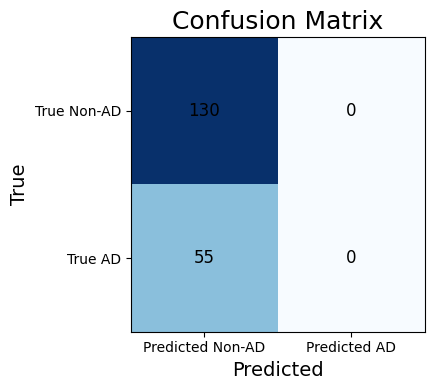

In [9]:
# Compute metrics
acc = accuracy_score(y_te, y_pred)
auc = roc_auc_score(y_te, y_prob)

# Precision and Recall
cm = confusion_matrix(y_te, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp + 1e-12)
recall = tp / (tp + fn + 1e-12)

# Display results in a DataFrame
summary_df = pd.DataFrame([{
    "Model": "vit_scratch",
    "Accuracy %": round(acc*100),
    "Precision %": round(precision*100),
    "Recall %": round(recall*100),
    "AUC %": round(auc*100),
}])
display(summary_df.style.hide(axis="index"))

# Confusion matrix heatmap
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
im = ax.imshow(cm, interpolation='nearest', cmap="Blues")
ax.set_title(f"Confusion Matrix", fontsize=18)
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels([f"Predicted Non-AD", f"Predicted AD"])
ax.set_yticklabels([f"True Non-AD", f"True AD"])

# annotate counts
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
ax.set_xlabel("Predicted", fontsize=14); ax.set_ylabel("True", fontsize=14)
plt.tight_layout()
plt.show()

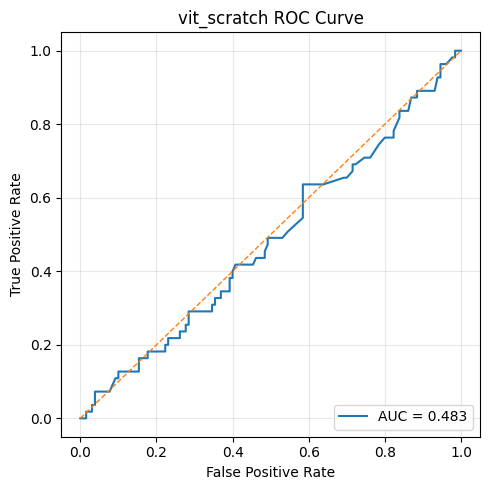

In [10]:
# ROC curve
fpr, tpr, thr = roc_curve(y_te, y_prob)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], '--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("vit_scratch ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

True Positives (AD correctly detected): none


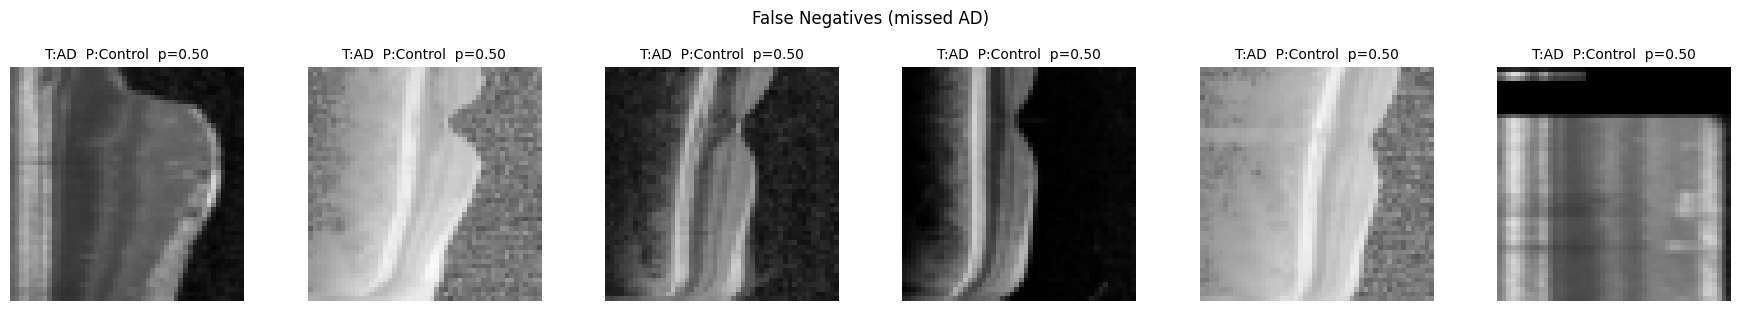

False Positives (non-AD flagged as AD): none


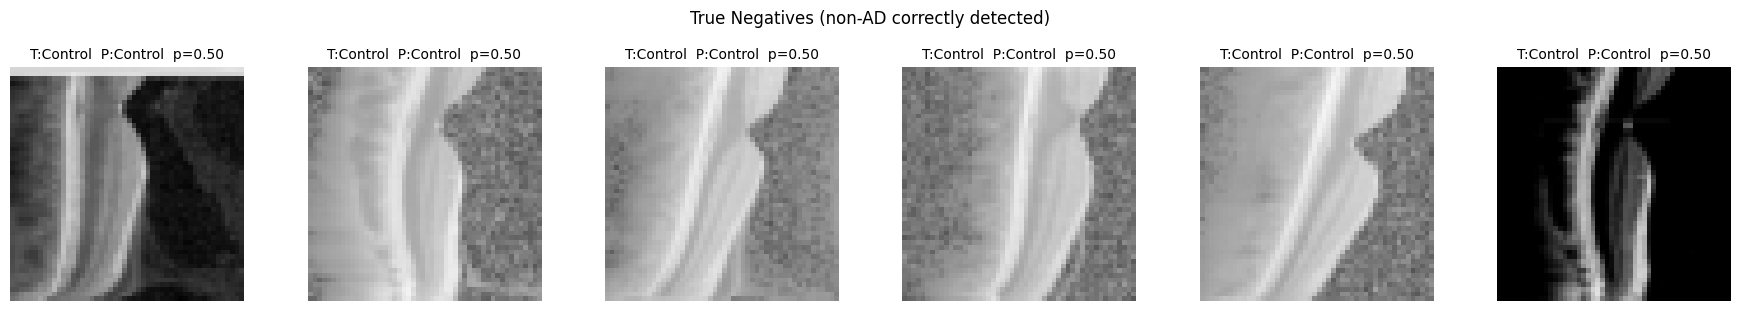

In [11]:
# Visualize some example predictions
rng = np.random.default_rng(0)
TP = np.where((y_te == 1) & (y_pred == 1))[0]
TN = np.where((y_te == 0) & (y_pred == 0))[0]
FP = np.where((y_te == 0) & (y_pred == 1))[0]
FN = np.where((y_te == 1) & (y_pred == 0))[0]

def show_examples(indices, n=8, cols=4, title=None):
    """Function show_examples to display example images with predictions

        Args:
            indices (np.ndarray): Indices of samples to display
            n (int): Number of samples to display
            cols (int): Number of columns in the display grid
            title (str or None): Title for the display

    """
    # handle empty case
    if len(indices) == 0:
        print(f"{title or 'Samples'}: none")
        return
    # randomly select n samples if more are available
    sel = indices if len(indices) <= n else rng.choice(indices, size=n, replace=False)
    rows = math.ceil(len(sel) / cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i, k in enumerate(sel):
        img = X_te[k]

        # squeeze grayscale channel if present
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax.axis("off")
        ax.set_title(f"T:{class_names[int(y_te[k])]}  "
                     f"P:{class_names[int(y_pred[k])]}  "
                     f"p={y_prob[k]:.2f}",
                     fontsize=10)
    if title:
        plt.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

show_examples(TP, n=6, cols=6, title="True Positives (AD correctly detected)")
show_examples(FN, n=6, cols=6, title="False Negatives (missed AD)")
show_examples(FP, n=6, cols=6, title="False Positives (non-AD flagged as AD)")
show_examples(TN, n=6, cols=6, title="True Negatives (non-AD correctly detected)")